In [30]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import glob
import scipy.stats as stats
from matplotlib.colors import LogNorm, SymLogNorm
from dataclasses import dataclass
import matplotlib
from mpl_toolkits.axes_grid1 import AxesGrid

In [193]:
path = "/home/cluster/hlasco/bulk1/turbulence/compressible/256/calibration"
sim_list = sorted(glob.glob(path + "/mach_*/"))
mach_list = [int(m[-3:-1]) for m in sim_list]
for i in range(len(mach_list)):
    sim_list[i] = glob.glob(sim_list[i] + "*/run/processed_data/snapshot.h5")
    if sim_list[i] == []:
        mach_list.pop(i)
try:
    sim_list.remove([])
except:
    pass
print(mach_list)

[1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]


In [194]:
@dataclass
class turb_fields:
    mach: float
    ux: np.array(float)
    uy: np.array(float)        
    uz: np.array(float)        
    r:  np.array(float)        
    k:  np.array(float)        
    Es: np.array(float)
    Ec: np.array(float)
    E:  np.array(float)
    P:  np.array(float)
    att: dict()


In [195]:
def readSnapshot(file, mach):
    with h5.File(file[0], 'r') as f:
        att = dict(f["HR"].attrs)
        k = np.array(f['HR/k'])
        P = np.array(f['HR/P'])
        Es = np.array(f['HR/Es'])
        Ec = np.array(f['HR/Ec'])
        E = Es + Ec
        
        ux = np.array(f['HR/ux'])
        uy = np.array(f['HR/uy'])
        uz = np.array(f['HR/uz'])
        r = np.array(f['HR/rho'])
    return turb_fields(mach, ux, uy, uz, r, k, Es, Ec, E, P, att)

In [196]:
tf_list = [readSnapshot(sim_list[i], mach_list[i]) for i in range(len(mach_list))]

In [197]:
def grad(inpt, axis):
    dx = 1.0/inpt.shape[1]
    ret = np.gradient(inpt, dx, axis=axis)
    return ret

def get_velocity_grad(f):
    
    dudx = grad(f.ux,0)
    dudy = grad(f.ux,1)
    dudz = grad(f.ux,2)
    dvdx = grad(f.uy,0)
    dvdy = grad(f.uy,1)
    dvdz = grad(f.uy,2)
    dwdx = grad(f.uz,0)
    dwdy = grad(f.uz,1)
    dwdz = grad(f.uz,2)

    return dudx, dvdx, dwdx, dudy, dvdy, dwdy, dudz, dvdz, dwdz

def get_vorticity(f):
    dudx, dvdx, dwdx, dudy, dvdy, dwdy, dudz, dvdz, dwdz = get_velocity_grad(f)
    vort_x = dwdy - dvdz
    vort_y = dudz - dwdx
    vort_z = dvdx - dudy
    return np.stack((vort_x, vort_y, vort_z))

In [198]:
def get_ks(k,E, cs):
    E_ls = .5*cs**2
    
    sum_E = [np.sum(E[i:]) for i in range(len(k))]
    diff_E = np.fabs(np.array(sum_E) - E_ls)
    return k[np.argmin(diff_E)]
    

0.9517166510424833
0.993291903033576
1.032608104285284
1.0464296633967838
1.0120609238340108
1.065132385085705
1.064814183404279
1.0751042984174843
0.9661792768320824
0.9835436927378988
1.024522910677152


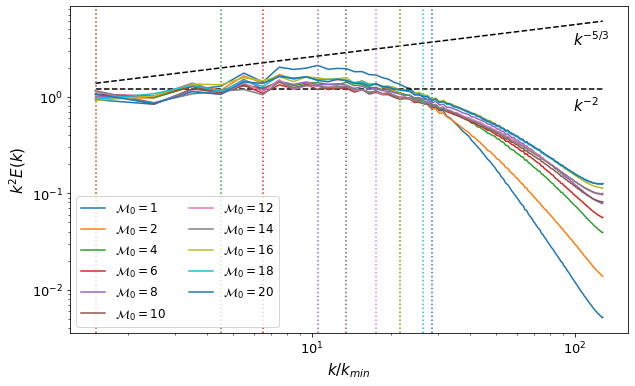

In [277]:
m = 2
plt.figure(figsize=(10,6))
cs = 0.18656300264905473
for i, f in enumerate(tf_list):
    ks = get_ks(f.k, f.E, cs)
    y = f.k**m * f.E
    print(3*np.pi/4*np.sum(f.E/f.k)/np.sum(f.E))
    y = y / np.sum(f.E)
    plt.loglog(f.k, y, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))

    plt.axvline(x=ks, color='C{}'.format(i), linestyle=':')
    if i==0:
        plt.loglog(f.k, 1.2*(f.k)**(m-2), 'k--')
        plt.loglog(f.k, 1.2*(f.k)**(m-5./3), 'k--')
        plt.text(f.k[-30], (.7*(f.k)**(m-2))[-50], r'$k^{-2}$', fontsize=15)
        plt.text(f.k[-30], (.8*(f.k)**(m-5./3))[-50], r'$k^{-5/3}$', fontsize=15)
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$k^{2} E(k)$', fontsize=15)
plt.xlabel('$k / k_{min}$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

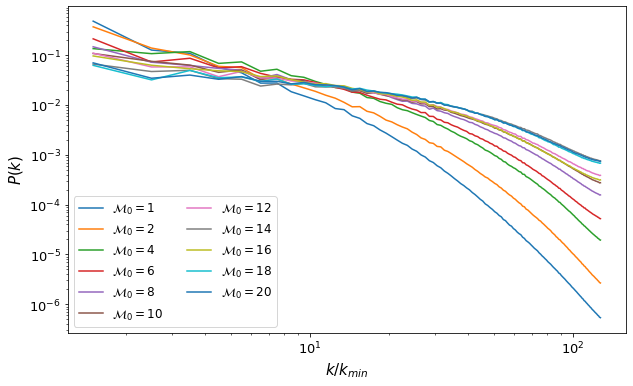

In [200]:
m = 0
plt.figure(figsize=(10,6))
for i, f in enumerate(tf_list):
    y = f.k**m * f.P
    y = y / np.sum(f.P)
    plt.loglog(f.k, y, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$P(k)$', fontsize=15)
plt.xlabel('$k / k_{min}$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

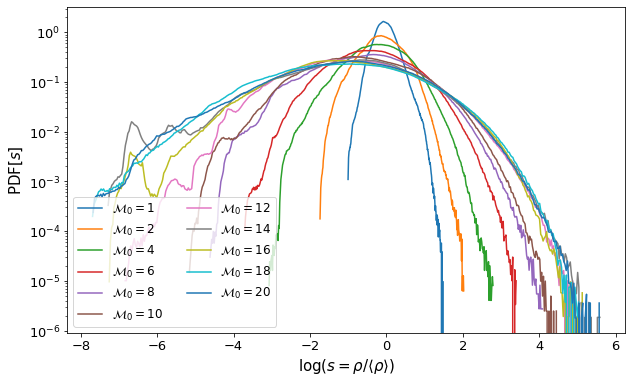

In [201]:
plt.figure(figsize=(10,6))
nBins = 400
for i, f in enumerate(tf_list):
    s = np.log(f.r/np.mean(f.r))
    hist, bin_edges = np.histogram(s, density=True, bins=nBins)
    bins = .5*(bin_edges[1:] + bin_edges[:-1])
    plt.semilogy(bins, hist, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel(r'$\mathrm{PDF}[s]$', fontsize=15)
plt.xlabel(r'$\mathrm{log}(s=\rho / \left<\rho\right>)$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=3, ncol=2)
plt.show()

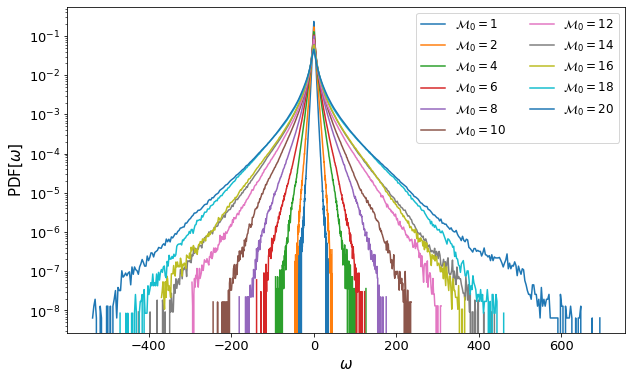

In [202]:
plt.figure(figsize=(10,6))
nBins = 400
for i, f in enumerate(tf_list):
    w = get_vorticity(f)
    hist, bin_edges = np.histogram(w, density=True, bins=nBins)
    bins = .5*(bin_edges[1:] + bin_edges[:-1])
    plt.semilogy(bins, hist, label=r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), c='C{}'.format(i))
plt.legend(fontsize=15, loc=4, ncol=2)


plt.ylabel('$\mathrm{PDF}[\omega]$', fontsize=15)
plt.xlabel('$\omega$', fontsize=15)
plt.tick_params(axis='both', labelsize=13)

plt.legend(fontsize=12, loc=1, ncol=2)
plt.show()

In [203]:
# set the colormap and centre the colorbar
class MidpointNormalize(matplotlib.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

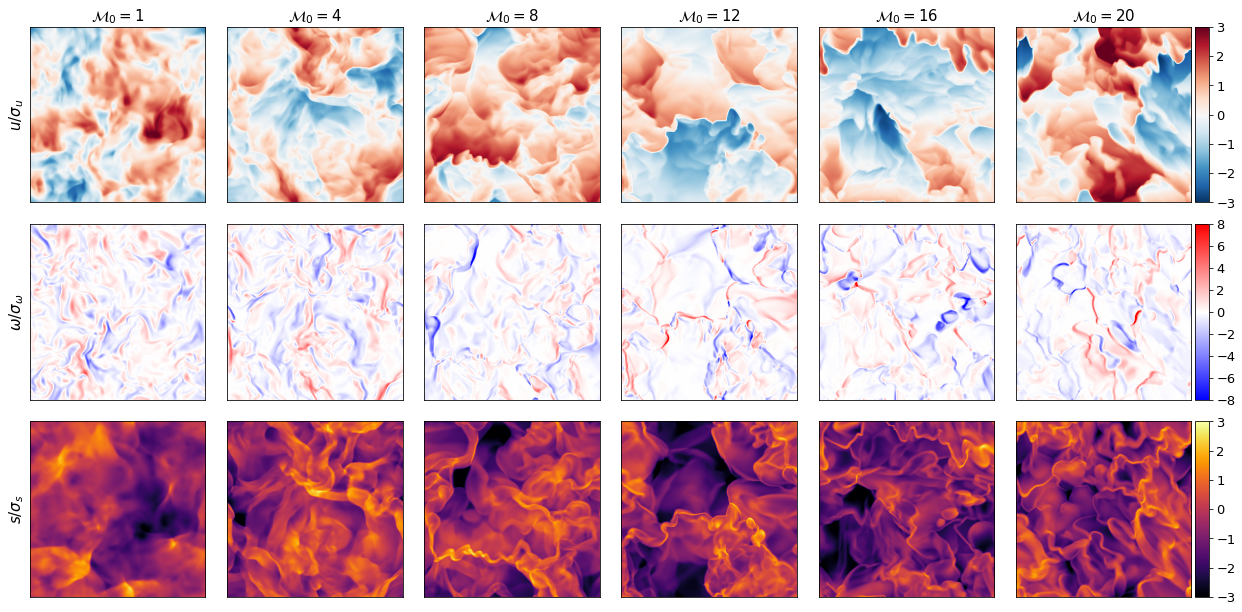

In [216]:
matplotlib.rcParams['mpl_toolkits.legacy_colorbar'] = False
params = matplotlib.figure.SubplotParams(left=.01, right=0.92, bottom=0.03, top=0.95)
skip=2
ncols=len(tf_list[::skip])
nrows=3
fig = plt.figure(1, (6*nrows, 4*ncols), subplotpars=params)

grid = AxesGrid(fig, 111, nrows_ncols = (nrows, ncols), 
                axes_pad=0.3, cbar_mode='edge', cbar_size=.2,cbar_pad=.05)

for i, f in enumerate(tf_list[::skip]):
    
    grid[i].set_title(r"$\mathcal{{M}}_{{0}}={mach}$".format(mach=f.mach), fontsize=15)
    
    w = get_vorticity(f)

    sdev_vel = (1./3*(f.att['ux_std2'] + f.att['uy_std2'] + f.att['uz_std2']))**.5
    mean_vel = f.att['ux_mean'] + f.att['uy_mean'] + f.att['uz_mean']
    u = (f.ux[:,:,128]-mean_vel)/sdev_vel
    
    sdev_w = np.std(w)
    w = w[0,:,:,128]/sdev_w
    
    s = np.log(f.r/np.mean(f.r))
    sdev_s = np.std(s)
    s = s[:,:,128]/sdev_s

    im1 = grid[i].imshow(u, cmap='RdBu_r',norm=MidpointNormalize(-3, 3, 0.))
    im2 = grid[i+ncols].imshow(w, cmap='bwr',norm=MidpointNormalize(-8, 8, 0.)) 
    im3 = grid[i+2*ncols].imshow(s, cmap='inferno',norm=MidpointNormalize(-3, 3, 0.)) 
    
for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

grid[0].set_ylabel(r"$u / \sigma_{u}$", fontsize=15)
grid[ncols].set_ylabel(r"$\omega / \sigma_{\omega}$", fontsize=15)
grid[2*ncols].set_ylabel(r"$s / \sigma_{s}$", fontsize=15)

grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[0].tick_params(labelsize=13) 
grid.cbar_axes[1].colorbar(im2)
grid.cbar_axes[1].tick_params(labelsize=13)
grid.cbar_axes[2].colorbar(im3)
grid.cbar_axes[2].tick_params(labelsize=13)
plt.show()

In [86]:
snap = "/home/cluster/hlasco/bulk1/incompressible/HITDNS03RK_UW_CFL010_BPD32_EXT2pi_RE205/spectralAnalysis.raw"

In [84]:
with h5.File(snap, 'r') as f:
    print(f.keys())
    vel = np.array(f['data'])
    print(vel.shape)

<KeysViewHDF5 ['data', 'vx', 'vy', 'vz']>
(512, 512, 512, 3)


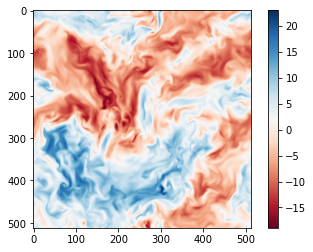

In [85]:
plt.imshow(vel[:,:,0,0], cmap='RdBu')
plt.colorbar()

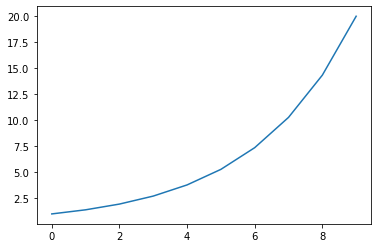

In [221]:
plt.plot(np.geomspace(1, 20, 10))

In [272]:
(np.array([1,2,3,4,6,8,10,12,16,20,24,28])/np.sqrt(3))

array([ 0.57735027,  1.15470054,  1.73205081,  2.30940108,  3.46410162,
        4.61880215,  5.77350269,  6.92820323,  9.23760431, 11.54700538,
       13.85640646, 16.16580754])

In [239]:
20*20*.5

200.0

In [232]:
sorted(['mach_1.00', 'mach_2.00','mach_10.00'])

['mach_1.00', 'mach_10.00', 'mach_2.00']

In [267]:
def get_tcross(box, temp, mach, mu=2.37):
    kb_cgs = 1.38064852e-16
    mH_cgs = 1.6737236e-24
    myr_cgs = 1e6*3.1556926e7

    cs = np.sqrt(temp * kb_cgs / (mu*mH_cgs)) # cgs

    pc_cgs = 3.0857e18
    t_cross = box * pc_cgs / (3**.5*mach * cs)

    return t_cross / myr_cgs

In [270]:
get_tcross(100,10,100)

3.026027418593497